In [1]:
# script to plot vertical profiles of some TOGA tracers
# include plain scatter, boxplots per KM, and sampling distribution 
# author: sofia chelpon
# created: Feb 11, 2020 

In [1]:
import numpy as np 
import xarray as xr
import pandas as pd 
import datetime 
import seaborn as sns

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits import mplot3d

%matplotlib inline
%config inlinebackend.figure_format='retina'

In [2]:
mypath1 = '/Volumes/scdrive2/TTS_2020/contrast_readin/toga_lodhalf/toga_trace_gases.nc'
toga_trc = xr.open_dataset(mypath1)
toga_trc

### --- dont want <LOD fill values in vertical profiles 
for ii in toga_trc.data_vars:
    # get this tracer and its LOD 
    trc_vals = toga_trc[ii].values
    trc = toga_trc[ii]
    # -------- locations for fills
    fill = trc.LOD/2
    where_fill = np.where(trc_vals == fill)
    # -------- make those locations equal to LOD/2 
    trc_vals[where_fill] = np.nan
    #trc_vals[where_ulod] = trc.LOD/2
    # replace values in Dataarray with that including substituded values, save to var 
    trc.values = trc_vals
    toga_trc[ii] = trc

In [3]:
# put desired toga data into a dataframe for easier chunking 
alt_bins = np.arange(0,17,1)
alt_bin_labels = np.arange(0.5, 16.5, 1)

toga_df = pd.DataFrame({"GGALT [km]": toga_trc.GGALT/1000})
toga_df['alt_bins'] = pd.cut(toga_df['GGALT [km]'], bins=alt_bins, labels=alt_bin_labels)

# add all tracers back in 
for ii in toga_trc.data_vars:
    toga_df[str(ii)] = toga_trc[ii]

# index to height bin (center of KM)
toga_df = toga_df.drop(columns="GGALT [km]")
toga_df.set_index('alt_bins')

,Acetaldehyde,n_Butane,i_Butane,Benzene,C3H8,Methanol,Bromoform,Tetrachloroethylene,Dibromomethane,Dichloromethane,Chloroform,Carbon_Tetrachloride
alt_bins,,,,,,,,,,,,
3.5,191.199997,1.51,2.49,NaN,41.0,611.0,0.689,NaN,NaN,44.490002,9.39,97.099998
4.5,126.800003,1.68,2.60,NaN,13.0,378.0,0.480,NaN,NaN,50.110001,10.29,94.300003
5.5,NaN,1.42,2.17,7.28,18.0,228.0,NaN,NaN,NaN,42.029999,8.67,96.699997
6.5,116.900002,1.14,1.09,8.23,NaN,327.0,0.625,NaN,1.043,43.689999,9.42,94.599998
7.5,NaN,3.01,2.26,5.28,22.0,NaN,NaN,NaN,1.001,49.049999,9.29,93.400002
...,...,...,...,...,...,...,...,...,...,...,...,...
8.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
##### ----- count number of measurements per km bin for each tracer 
# for sampling histogram
toga_df_count = pd.DataFrame(index = alt_bin_labels)
toga_df_count.index.name = 'bin_centers'

for ii in toga_trc.data_vars:
    count = toga_df.groupby('alt_bins')[str(ii)].count()
    toga_df_count[str(ii)] = count.tolist()

In [5]:
# keep only counts that we want to plot 
toga_df_count_forplot = toga_df_count.drop(columns = ['n_Butane', 'i_Butane', 'C3H8', 'Methanol', 
                                                     'Dibromomethane', 'Chloroform'])

In [6]:
# get some colors
color_awas = [0.05, 0.09, 0.66]

myreds = matplotlib.cm.get_cmap('Reds')

color_toga = myreds(0.55)
color_toga = color_toga[0:3]

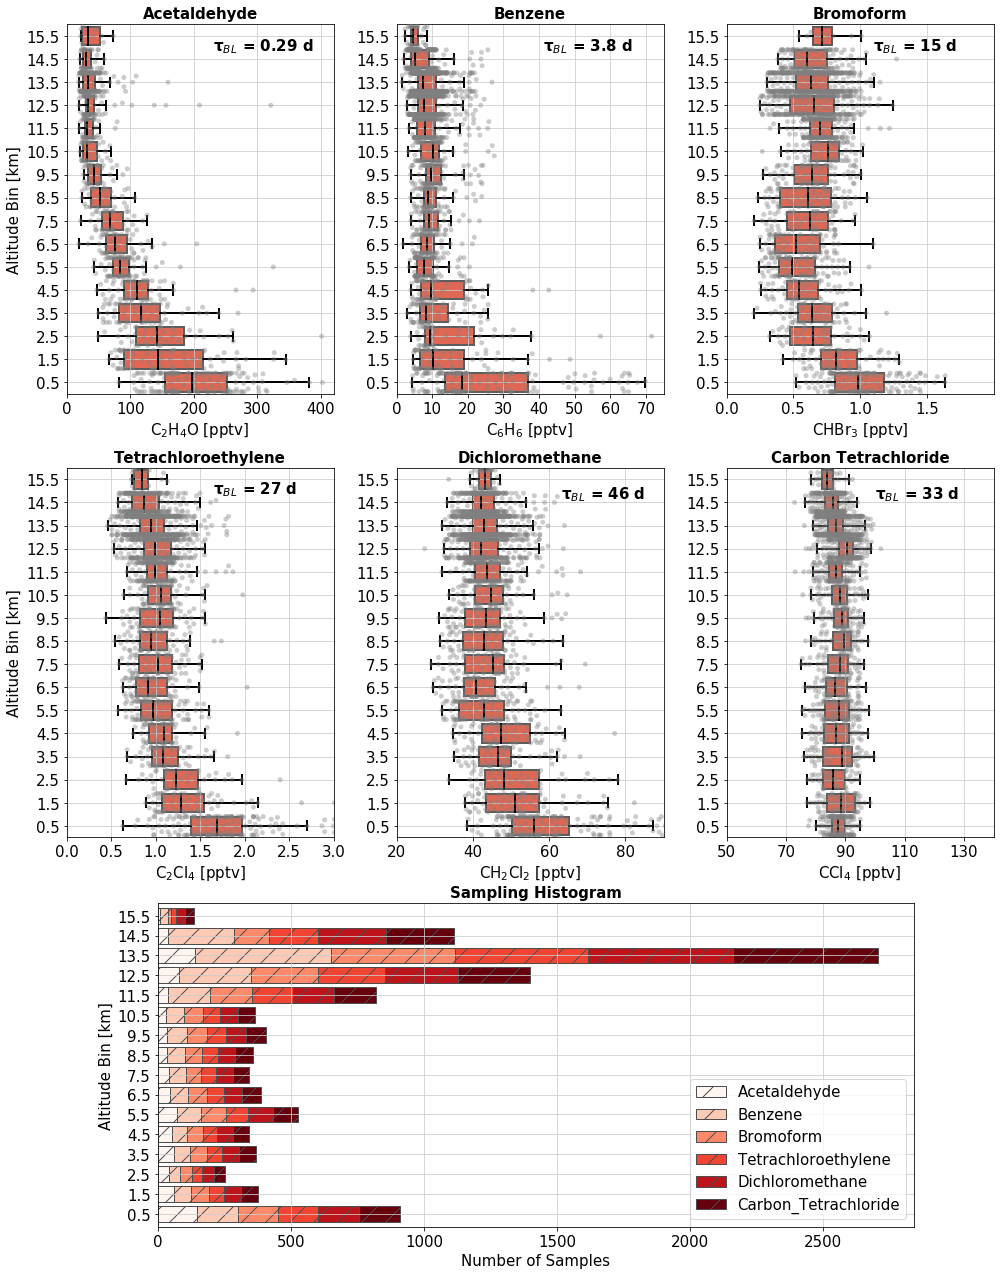

In [7]:
##### ----------------------------- make my axes to fill 
# https://matplotlib.org/gallery/subplots_axes_and_figures/gridspec_and_subplots.html
fig, axs = plt.subplots(figsize = (14,18), ncols=3, nrows=3)
gs = axs[2, 2].get_gridspec()

# remove the underlying axes
for ax in axs[2, -3:]:
    ax.remove()

##### ----------------------------- POPULATE PLOT 
#### acetaldehyde ------------------------------------------------------------------
# target axis 
axs[0, 0] = sns.boxplot(x = 'Acetaldehyde', y = 'alt_bins', data = toga_df, linewidth = 2, whis = 1.5, 
                        color = color_toga, showfliers = False, ax = axs[0, 0], order = np.flipud(alt_bin_labels))
axs[0, 0] = sns.swarmplot(x = 'Acetaldehyde', y = 'alt_bins', data = toga_df, 
                          color = '0.5', alpha = 0.4, ax = axs[0, 0], order = np.flipud(alt_bin_labels))
plt.setp(axs[0, 0].lines, color = 'k')

# lifetime 
tau = toga_trc.Acetaldehyde.BL_lifetime 
tau2 = round(tau, 2)
tau_str = '\N{GREEK SMALL LETTER TAU}'+ '$_B$$_L$' + ' = ' + str(tau2) + ' d'

# axes, labels, ticks, .... 
axs[0, 0].set_title('Acetaldehyde', fontsize = 15, weight = 'bold') 
axs[0, 0].set_ylabel('Altitude Bin [km]', fontsize = 15) 

axs[0, 0].set_xlim([0, 420])
axs[0, 0].set_xticks(np.arange(0, 500, step = 100))
axs[0, 0].set_xlabel(r'C$_2$H$_4$O [pptv]', fontsize=15)

axs[0, 0].tick_params(axis='both', which='major', labelsize=15)
axs[0, 0].grid(which='major', linestyle='-', color = '0.8')

axs[0, 0].annotate(tau_str, (0, 0), xytext=(0.55, 0.93), 
                   textcoords='axes fraction', fontsize = 15, weight='bold')

#### benzene ------------------------------------------------------------------
# target axis 
axs[0, 1] = sns.boxplot(x = 'Benzene', y = 'alt_bins', data = toga_df, linewidth = 2, whis = 1.5, 
                        color = color_toga, showfliers = False, ax = axs[0, 1], order = np.flipud(alt_bin_labels))
axs[0, 1] = sns.swarmplot(x = 'Benzene', y = 'alt_bins', data = toga_df, 
                          color = '0.5', alpha = 0.4, ax = axs[0, 1], order = np.flipud(alt_bin_labels))
plt.setp(axs[0, 1].lines, color = 'k')

# lifetime 
tau = toga_trc.Benzene.BL_lifetime 
tau2 = round(tau, 1)
tau_str = '\N{GREEK SMALL LETTER TAU}'+ '$_B$$_L$' + ' = ' + str(tau2) + ' d'

# axes, labels, ticks, .... 
axs[0, 1].set_title('Benzene', fontsize = 15, weight = 'bold') 
axs[0, 1].set_ylabel('') 

axs[0, 1].set_xlim([0, 75])
axs[0, 1].set_xticks(np.arange(0, 80, step = 10))
axs[0, 1].set_xlabel(r'C$_6$H$_6$ [pptv]', fontsize=15)

axs[0, 1].tick_params(axis='both', which='major', labelsize=15)
axs[0, 1].grid(which='major', linestyle='-', color = '0.8')

axs[0, 1].annotate(tau_str, (0, 0), xytext=(0.55, 0.93), 
                   textcoords='axes fraction', fontsize = 15, weight='bold')


#### bromoform ------------------------------------------------------------------
# target axis 
axs[0, 2] = sns.boxplot(x = 'Bromoform', y = 'alt_bins', data = toga_df, linewidth = 2, whis = 1.5, 
                        color = color_toga, showfliers = False, ax = axs[0, 2], order = np.flipud(alt_bin_labels))
axs[0, 2] = sns.swarmplot(x = 'Bromoform', y = 'alt_bins', data = toga_df, 
                          color = '0.5', alpha = 0.4, ax = axs[0, 2], order = np.flipud(alt_bin_labels))
plt.setp(axs[0, 2].lines, color = 'k')

# lifetime 
tau = toga_trc.Bromoform.BL_lifetime 
tau2 = int(round(tau))
tau_str = '\N{GREEK SMALL LETTER TAU}'+ '$_B$$_L$' + ' = ' + str(tau2) + ' d'

# axes, labels, ticks, .... 
axs[0, 2].set_title('Bromoform', fontsize = 15, weight = 'bold') 
axs[0, 2].set_ylabel('') 

axs[0, 2].set_xlim([0, 2])
axs[0, 2].set_xticks(np.arange(0, 2, step = 0.5))
axs[0, 2].set_xlabel(r'CHBr$_3$ [pptv]', fontsize=15)

axs[0, 2].tick_params(axis='both', which='major', labelsize=15)
axs[0, 2].grid(which='major', linestyle='-', color = '0.8')

axs[0, 2].annotate(tau_str, (0, 0), xytext=(0.55, 0.93), 
                   textcoords='axes fraction', fontsize = 15, weight='bold')

#### tetracholoethylene ------------------------------------------------------------------
# target axis 
axs[1, 0] = sns.boxplot(x = 'Tetrachloroethylene', y = 'alt_bins', data = toga_df, linewidth = 2, whis = 1.5, 
                        color = color_toga, showfliers = False, ax = axs[1, 0], order = np.flipud(alt_bin_labels))
axs[1, 0] = sns.swarmplot(x = 'Tetrachloroethylene', y = 'alt_bins', data = toga_df, 
                          color = '0.5', alpha = 0.4, ax = axs[1, 0], order = np.flipud(alt_bin_labels))
plt.setp(axs[1, 0].lines, color = 'k')

# lifetime 
tau = toga_trc.Tetrachloroethylene.BL_lifetime 
tau2 = int(round(tau))
tau_str = '\N{GREEK SMALL LETTER TAU}'+ '$_B$$_L$' + ' = ' + str(tau2) + ' d'

# axes, labels, ticks, .... 
axs[1, 0].set_title('Tetrachloroethylene', fontsize = 15, weight = 'bold') 
axs[1, 0].set_ylabel('Altitude Bin [km]', fontsize = 15) 

axs[1, 0].set_xlim([0, 3])
axs[1, 0].set_xticks(np.arange(0, 3.5, step = 0.5))
axs[1, 0].set_xlabel(r'C$_2$Cl$_4$ [pptv]', fontsize=15)

axs[1, 0].tick_params(axis='both', which='major', labelsize=15)
axs[1, 0].grid(which='major', linestyle='-', color = '0.8')

axs[1, 0].annotate(tau_str, (0, 0), xytext=(0.55, 0.93), 
                   textcoords='axes fraction', fontsize = 15, weight='bold')

#### dichloromethane ------------------------------------------------------------------
# target axis 
axs[1, 1] = sns.boxplot(x = 'Dichloromethane', y = 'alt_bins', data = toga_df, linewidth = 2, whis = 1.5, 
                        color = color_toga, showfliers = False, ax = axs[1, 1], order = np.flipud(alt_bin_labels))
axs[1, 1] = sns.swarmplot(x = 'Dichloromethane', y = 'alt_bins', data = toga_df, 
                          color = '0.5', alpha = 0.4, ax = axs[1, 1], order = np.flipud(alt_bin_labels))
plt.setp(axs[1, 1].lines, color = 'k')

# lifetime 
tau = toga_trc.Dichloromethane.BL_lifetime 
tau2 = int(round(tau))
tau_str = '\N{GREEK SMALL LETTER TAU}'+ '$_B$$_L$' + ' = ' + str(tau2) + ' d'

# axes, labels, ticks, .... 
axs[1, 1].set_title('Dichloromethane', fontsize = 15, weight = 'bold') 
axs[1, 1].set_ylabel('') 

axs[1, 1].set_xlim([20, 90])
axs[1, 1].set_xticks(np.arange(20, 100, step = 20))
axs[1, 1].set_xlabel(r'CH$_2$Cl$_2$ [pptv]', fontsize=15)

axs[1, 1].tick_params(axis='both', which='major', labelsize=15)
axs[1, 1].grid(which='major', linestyle='-', color = '0.8')

axs[1, 1].annotate(tau_str, (63, 14.5), xytext=(63, 0.83), fontsize = 15, weight='bold')
#axs[1, 1].annotate(tau_str, (0, 0), xytext=(0.5, 0.93), 
#                   textcoords='axes fraction', fontsize = 15, weight='bold')


#### carbon tetrachloride ------------------------------------------------------------------
# target axis 
# target axis 
axs[1, 2] = sns.boxplot(x = 'Carbon_Tetrachloride', y = 'alt_bins', data = toga_df, linewidth = 2, whis = 1.5, 
                        color = color_toga, showfliers = False, ax = axs[1, 2], order = np.flipud(alt_bin_labels))
axs[1, 2] = sns.swarmplot(x = 'Carbon_Tetrachloride', y = 'alt_bins', data = toga_df, 
                          color = '0.5', alpha = 0.4, ax = axs[1, 2], order = np.flipud(alt_bin_labels))
plt.setp(axs[1, 2].lines, color = 'k')

# lifetime 
tau = (toga_trc.Carbon_Tetrachloride.BL_lifetime)/365
tau2 = int(round(tau))
tau_str = '\N{GREEK SMALL LETTER TAU}'+ '$_B$$_L$' + ' = ' + str(tau2) + ' d'

# axes, labels, ticks, .... 
axs[1, 2].set_title('Carbon Tetrachloride', fontsize = 15, weight = 'bold') 
axs[1, 2].set_ylabel('') 

axs[1, 2].set_xlim([50, 140])
axs[1, 2].set_xticks(np.arange(50, 140, step = 20))
axs[1, 2].set_xlabel(r'CCl$_4$ [pptv]', fontsize=15)

axs[1, 2].tick_params(axis='both', which='major', labelsize=15)
axs[1, 2].grid(which='major', linestyle='-', color = '0.8')

axs[1, 2].annotate(tau_str, (100, 14.5), xytext=(100, 0.83), fontsize = 15, weight='bold')

#axs[1, 2].annotate(tau_str, (0, 0), xytext=(0.5, 0.93), 
#                   textcoords='axes fraction', fontsize = 15, weight='bold')

# squeeeeeeeze
fig.tight_layout()


##### ----------------------------- ADD BIG PLOT AT BOTTOM
# add bigger one in its place 
#axbig = fig.add_subplot(gs[2, -3:])
axbig = fig.add_axes([0.16, 0.05, 0.75, 0.25])

axbig.set_title('Sampling Histogram', fontsize = 15, weight = 'bold') 
toga_df_count_forplot.plot(kind='barh', stacked=True, colormap='Reds',  
                           hatch='/', width = 0.8, ax = axbig, fontsize = 15, edgecolor='0.3')
axbig.set_ylabel('Altitude Bin [km]', fontsize = 15) 
axbig.set_xlabel('Number of Samples', fontsize = 15) 
axbig.grid(which='major', linestyle='-', color = '0.8')
axbig.legend(fontsize = 15)

##### ----------------------------- save
fig.savefig('toga_vertical_profiles.svg', format='svg', dpi=1200)
fig.savefig('toga_vertical_profiles.pdf')  